In [42]:
##TODO
# Customers with the highest number of orders (betting on Sweden)
# Check the quarterly revenue behaviour
# Check monthly customer growth rate
# Check individuals vs wholesalers customers
# Note the issues with the dataset
## IF I have time, try to "interactivise" some more plots

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
from bokeh.embed import components
from bokeh.models import Circle, MultiLine
from bokeh.plotting import figure, from_networkx, show, output_file
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option("display.precision", 2)
products=pd.read_csv("products.csv")
sales=pd.read_csv("sales.csv")
products=products.drop("Unnamed: 0",axis=1)
sales=sales.drop("Unnamed: 0",axis=1)
temp=sales[["invoice_date","total_sale"]]
sales["invoice_date"]=pd.to_datetime(sales["invoice_date"])
sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week
sales["month"]=pd.DatetimeIndex(sales["invoice_date"]).month
sales["year"]=pd.DatetimeIndex(sales["invoice_date"]).year
sales["weekday"]=pd.DatetimeIndex(sales["invoice_date"]).day_of_week

C:\Users\giorg\AppData\Local\Temp\ipykernel_17064\2013391992.py:18: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  sales["week"]=pd.DatetimeIndex(sales["invoice_date"]).week


In [2]:
# FUNCTIONS

def churn(x,i):
    j=i+1
    a=((x["Customers"].loc[(x["month"]==j) & x["month_end"]]).values)
    b=((x["Customers"].loc[(x["month"]==j) & x["month_beg"]]).values)
    c=(a-b)/a
    try:
        return(round(c.item()*100,2))
    except ValueError:
        return(0)

def hot_encode(x):
    if(x<=0):
        return(0)
    elif(x>=0):
        return(1)

def stringify(x):
    return(x.apply(lambda x:", ".join(list(x)))).astype("unicode")

def common_items(x):
    temp=pd.merge(sales,products,on="ASIN")
    temp=(temp[(temp["month"]==x)&(temp["year"]==2019)]
                    .groupby(by=["InvoiceNo","title",])["Quantity"]
                    .sum().unstack().reset_index().fillna(0)
                    .set_index("InvoiceNo"))
    temp_encoded=temp.applymap(hot_encode)
    frq_items=apriori(temp_encoded,min_support=0.04,use_colnames=True)
    rules=association_rules(frq_items, metric="lift", min_threshold=1.2)
    rules=rules.sort_values(["confidence","lift"], 
                        ascending=[False,False])
    rules["antecedents"]=stringify(rules["antecedents"])
    rules["consequents"]=stringify(rules["consequents"])
    return(rules[["antecedents","consequents","confidence"]])

def node(x):
    months={1:"January", 2:"February", 3:"March", 4:"April",
        5:"May", 6:"June", 7:"July", 8:"August",9:"September",
        10:"October", 11:"November", 12:"December"}
    title="Most common item pairs for "+months[x]+" 2019"
    g=nx.from_pandas_edgelist(common_items(x),
                            "antecedents","consequents","confidence")
    HOVER_TOOLTIPS=[("Product","@index")]
    nodegraph=figure(tooltips=HOVER_TOOLTIPS, 
                tools="pan,wheel_zoom,save",
                active_scroll="wheel_zoom",
                title=title)
    network_graph=from_networkx(g, nx.spring_layout)
    network_graph.node_renderer.glyph=Circle(size=15, 
                                            fill_color="crimson")
    network_graph.edge_renderer.glyph=MultiLine(line_alpha=0.5, 
                                                line_width=1)
    nodegraph.renderers.append(network_graph)
    return(nodegraph)

In [36]:
# Get a list of products that are above the 75th pctl in terms of
# volume sold
sales100=sales.copy(deep=True)
sales100=sales100.groupby(by="ASIN").sum().reset_index()
sales100=sales100.loc[sales100["total_sale"]>6.61e+04]
a=sales100.columns
a=[i for i in a if i not in("ASIN","total_sale")]
sales100.drop(a,axis=1,inplace=True)
sales100.rename({"total_sale":"Total sales"},axis=1,inplace=True)
# Get a list of products that are above the 75th pctl in terms of 
# total revenue
quantity100=sales.copy(deep=True)
quantity100=quantity100.groupby(by="ASIN").sum().reset_index()
quantity100=quantity100.loc[quantity100["Quantity"]>1336]
a=quantity100.columns
a=[i for i in a if i not in ("ASIN","Quantity")]
quantity100.drop(a,axis=1,inplace=True)
# Find the common items between the two lists
top100=pd.merge(sales100,quantity100,on="ASIN",how="inner")


In [40]:
# NOT CORRECT, WE CAN NOT CALCULATE CHURN RATE WITH EXISTING DATA
%%script false
# Let's calculate the customer's attrition on a monthly basis for 2019
attrition=pd.DataFrame({"month":range(1,13)})
temp=sales.copy(deep=True)
temp.loc[:,("Customers")]=1
temp=temp.loc[sales["year"]==2019]
temp=temp.groupby("invoice_date").sum()
temp.reset_index(inplace=True)
a=list(temp.columns)
a=[i for i in a if i not in ("invoice_date","Customers")]
temp.drop(a, axis=1, inplace=True)
temp["month"]=pd.DatetimeIndex(temp["invoice_date"]).month
temp["month_end"]=pd.DatetimeIndex(temp["invoice_date"]).is_month_end
temp["month_beg"]=pd.DatetimeIndex(temp["invoice_date"]).is_month_start

# Keep only dates that are on month's end / beginning
temp=temp.loc[(temp["month_end"]) | (temp["month_beg"])]

# Keep only months that we know the stats for both the start and end date
temp=temp.loc[temp.duplicated(subset="month",keep=False),:]
temp.reset_index(inplace=True)
for i in range(len(attrition)):
    attrition.loc[i,"change"]=churn(temp,i)

# Plot for better visualisation
fig,ax=plt.subplots(figsize=(12,4))
sns.lineplot(data=attrition, x="month", y="change", color="crimson")
plt.axhline(0)
plt.title("Customer attrition rate for each month")
plt.xlabel("Month of the year")
plt.ylabel("Change in %")

UsageError: Line magic function `%%script` not found.


In [5]:
attrition=pd.DataFrame({"month":range(1,13)})
temp=sales.copy(deep=True)
temp.loc[:,("Customers")]=1
temp=temp.loc[sales["year"]==2019]
temp=temp.groupby("invoice_date").sum()
temp.reset_index(inplace=True)
a=list(temp.columns)
a=[i for i in a if i not in ("invoice_date","Customers")]
temp.drop(a, axis=1, inplace=True)
temp["month"]=pd.DatetimeIndex(temp["invoice_date"]).month
temp["month_end"]=pd.DatetimeIndex(temp["invoice_date"]).is_month_end
temp["month_beg"]=pd.DatetimeIndex(temp["invoice_date"]).is_month_start

Text(0.5, 0, 'Inactive users defined as no transactionsin the last 6 months')

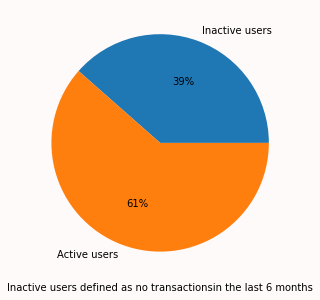

In [6]:
# Check for customers who haven't shopped for a while
temp=sales.groupby(by=["CustomerID","invoice_date"]).sum()
temp.reset_index(inplace=True)
a=list(temp.columns)
a=[i for i in a if i not in ("CustomerID","invoice_date")]
temp.drop(a,axis=1,inplace=True)
temp=temp.groupby(by="CustomerID")\
    .min().sort_values(by="invoice_date",ascending=False)
temp=len(temp.loc[temp["invoice_date"]<"2019-06-01"])
lst=[temp,sales["CustomerID"].nunique()]

# Plot them to visualise better
fig,ax=plt.subplots(figsize=(5,5),facecolor="snow")
label=["Inactive users","Active users"]
plt.pie(lst, labels=label, autopct="%1.0f%%")
plt.xlabel("Inactive users defined as no transactions"\
    "in the last 6 months")

[Text(0.5, 0, '')]

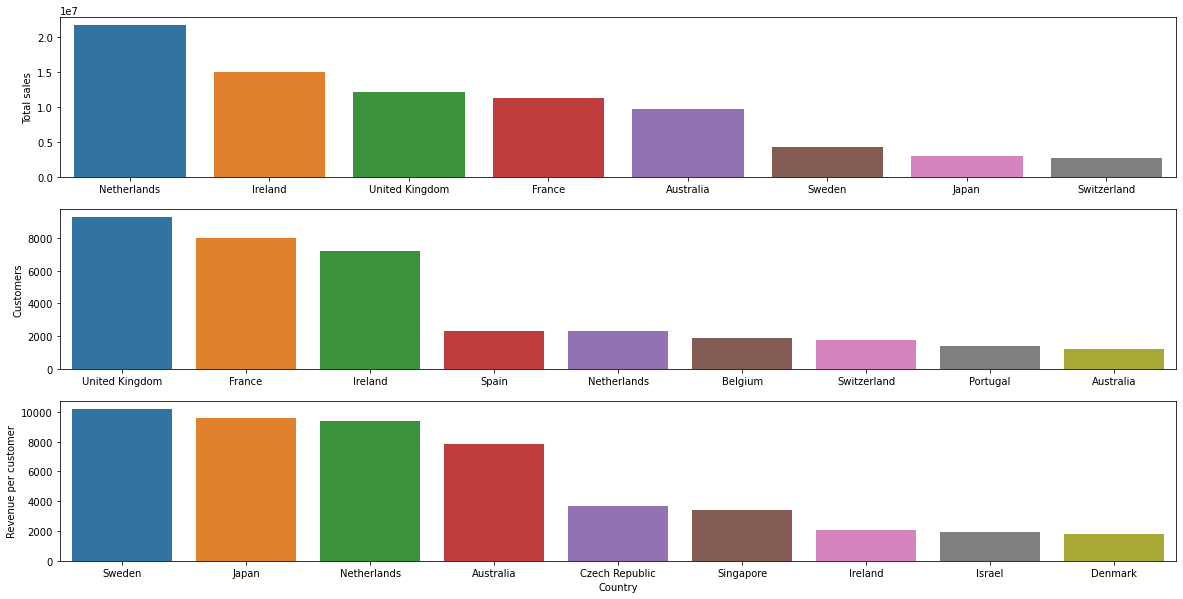

In [39]:
# Find the revenue per customer for each country 
temp=sales.copy(deep=True)
temp["ca"]=1
temp=temp.groupby(by="Country").sum()
a=list(temp.columns)
a=[i for i in a if i not in ("total_sale","ca")]
temp.drop(a,axis=1,inplace=True)
temp["Revenue per customer"]=temp["total_sale"]/temp["ca"]
temp.rename({"total_sale":"Total sales", "ca":"Customers"},
            axis=1, inplace=True)
temp.reset_index(inplace=True)

# Plot the top 8 from each column
fig,ax=plt.subplots(3,1,figsize=(20,10))
temp=temp.sort_values(by="Total sales",ascending=False)
temp.reset_index(inplace=True,drop=True)
sns.barplot(ax=ax[0],x=temp.loc[1:8,"Country"],
            y=temp.loc[1:8,"Total sales"])
temp=temp.sort_values(by="Customers",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[1],x=temp.loc[1:9,"Country"],
            y=temp.loc[1:9,"Customers"])
temp=temp.sort_values(by="Revenue per customer",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[2],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per customer"])
ax[0].set(xlabel="")
ax[1].set(xlabel="")

[Text(0.5, 0, '')]

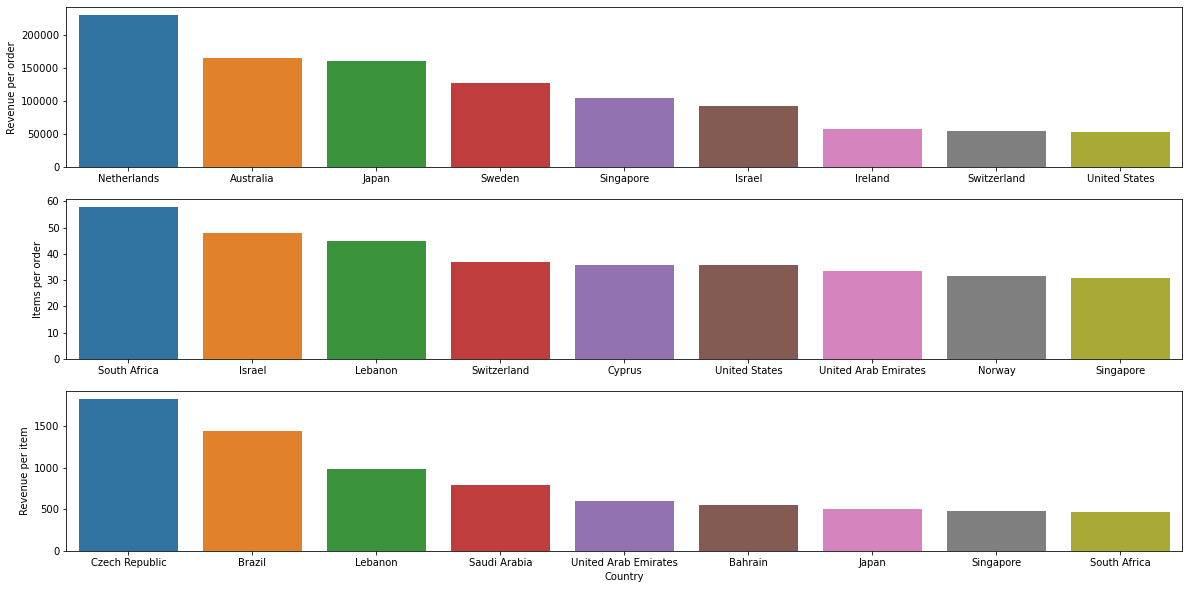

In [8]:
# Calculate average order size and revenue for each country
temp=sales.copy(deep=True)
temp["Items"]=1
temp=temp.groupby(by=["Country","InvoiceNo"]).sum()
temp.reset_index(inplace=True)
temp.rename({"weekday":"no_inv"},axis=1,inplace=True)
temp["no_inv"]=1
temp=temp.groupby(by="Country").sum()
temp["Items per order"]=temp["Items"]/temp["no_inv"]
temp["Revenue per order"]=temp["total_sale"]/temp["no_inv"]
temp["Revenue per item"]=temp["Revenue per order"]/temp["Items"]
a=list(temp.columns)
a=[i for i in a if i not in ("Items per order", 
    "Revenue per order", "Revenue per item")]
temp.drop(a,axis=1,inplace=True)

# Plot the top 8 from each column
fig,ax=plt.subplots(3,1,figsize=(20,10))
temp=temp.sort_values(by="Revenue per order",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[0],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per order"])
temp=temp.sort_values(by="Items per order",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[1],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Items per order"])
temp=temp.sort_values(by="Revenue per item",ascending=False)
temp.reset_index(inplace=True)
sns.barplot(ax=ax[2],x=temp.loc[0:8,"Country"],
            y=temp.loc[0:8,"Revenue per item"])
ax[0].set(xlabel="")
ax[1].set(xlabel="")

In [9]:
# Creating interactive plots for common item-pairs of 2019
# For each month we find through a series of functions the most common
# pairs. Then we plot an interactive network graph and save that figure
# in a list. Afterwards we extract the components "script" and "div" 
# of the figures and pass them to a bokeh template html file 
%%script false
plots=[]
for i in range(1,13):
    p=node(i)
    plots.append(p)    
script, div=components(plots)

UsageError: Line magic function `%%script` not found.


Text(0, 0.5, '')

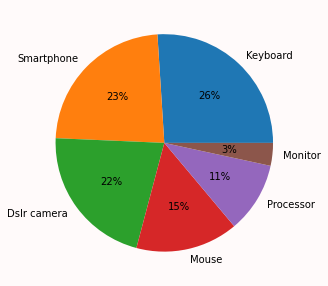

In [10]:
fig,ax=plt.subplots(figsize=(5,5),facecolor="snow")
temp=products["product_type"].value_counts()
label=[i for i in temp.index]
label=[i.capitalize() for i in label]
temp.plot.pie(
        labels=label, autopct="%1.0f%%")
ax.set_ylabel("")

Text(0.5, 0, 'Day of the week')

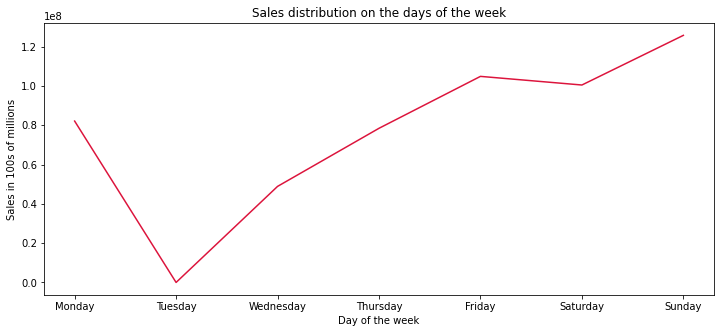

In [11]:
# Let's plot the total sales for each day of the week
# Interestingly enough, there are no orders on Tuesdays. 
# That can not be correct, so we assume it's due to date corruption 
temp=sales.groupby(by="weekday").sum()
a=list(temp.columns)
a=[i for i in a if i not in ("total_sale")]
temp.drop(a, axis=1, inplace=True)
temp.loc[1]=0
temp.reset_index(inplace=True)

fig,ax=plt.subplots(figsize=(12,5))
sns.lineplot(data=temp, x="weekday", y="total_sale",
            color="crimson")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday", "Tuesday", "Wednesday",
            "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Sales distribution on the days of the week")
plt.ylabel("Sales in 100s of millions")
plt.xlabel("Day of the week")

[Text(0.5, 1.0, 'Monthly average revenue'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Revenue in 10s of millions')]

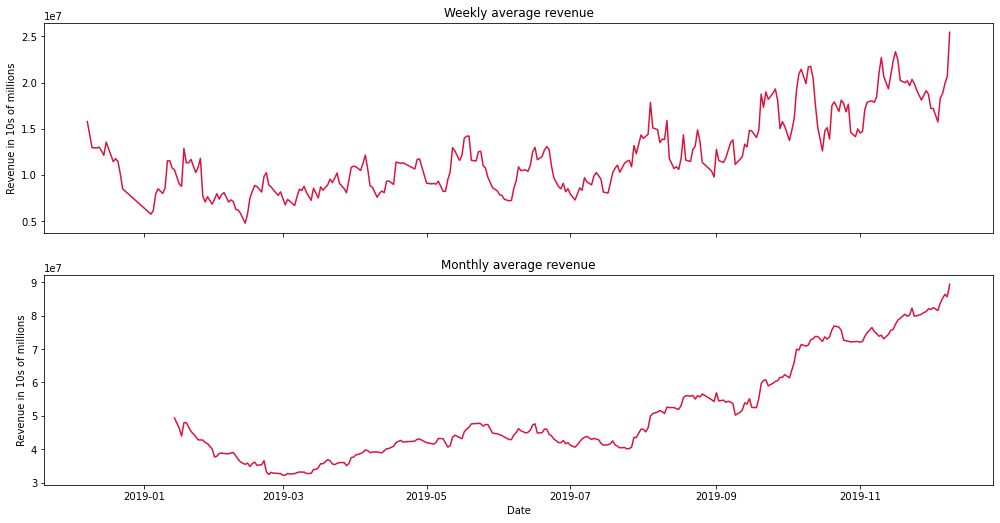

In [12]:
# Do it again but with better grouping and rolling averages
fig,ax=plt.subplots(2,1,figsize=(17,8.5),sharex=True)
temp=pd.merge(sales,products,on="ASIN")
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
temp["avg"]=(temp["total_sale"].rolling(7).sum())
sns.lineplot(ax=ax[0],x=temp["invoice_date"], y=temp["avg"],
        color="crimson")
temp["avg"]=(temp["total_sale"].rolling(30).sum())        
sns.lineplot(ax=ax[1],x=temp["invoice_date"], y=temp["avg"],
        color="crimson")        
ax[0].set(title="Weekly average revenue", xlabel="", 
        ylabel="Revenue in 10s of millions")
ax[1].set(title="Monthly average revenue", xlabel="Date", 
        ylabel="Revenue in 10s of millions")

Text(0.5, 0, 'Date')

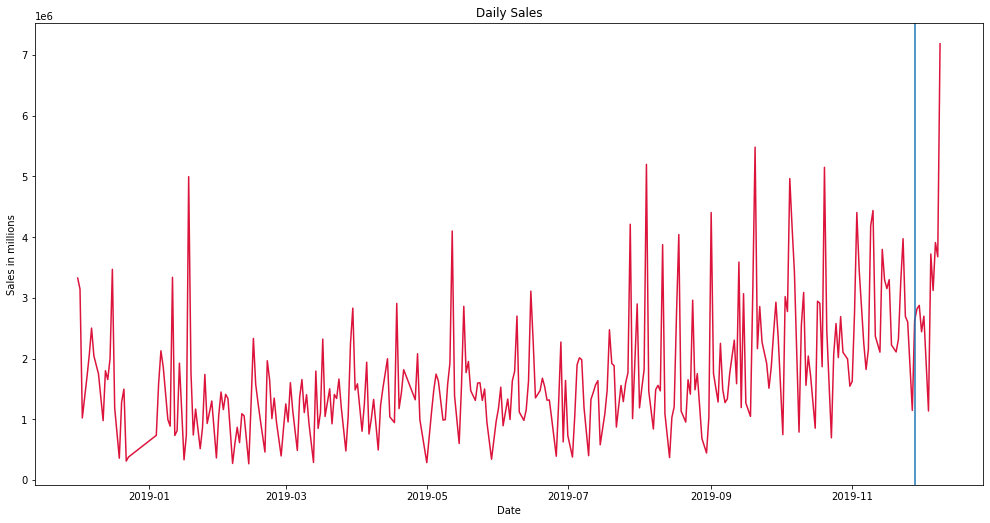

In [13]:
# Daily sales throughout the year, with Black Friday denoted by vertical line
fig,ax=plt.subplots(figsize=(17,8.5))
temp=sales
temp=temp.groupby(by="invoice_date").sum()
temp.reset_index(inplace=True)
sns.lineplot(x=temp["invoice_date"], y=temp["total_sale"],
        color="crimson")
lst=temp["invoice_date"].loc[temp["invoice_date"]=="2019-11-28"]
plt.axvline(lst)
plt.title("Daily Sales")
plt.ylabel("Sales in millions")
plt.xlabel("Date")

In [14]:
# Create an interactive plot for sales according to product type
%%script false
temp=pd.merge(sales,products,on="ASIN")
colours={1:"crimson",2:"fuchsia",3:"black",
        4:"royalblue",5:"orange",6:"limegreen"}
x=1
temp=temp.groupby(by=["week","product_type"]).sum()
temp.reset_index(inplace=True)
p = figure(width=1600, height=500, x_axis_type="datetime",
        tools="pan,wheel_zoom,save",active_scroll="wheel_zoom")
p.title.text="Sales breakdown based on product type"
for i in temp["product_type"].unique():
        df=temp.loc[temp["product_type"]==i]
        df["week"]=2019*100+df["week"]
        df["week"]=df["week"].astype(str)
        df["week"]=pd.to_datetime(df["week"].astype(str)+"0",
                                format='%Y%W%w')
        df["week1"]=df["week"].astype("str")
        p.line(df["week"],df["total_sale"],line_width=3, 
                color=colours[x], alpha=1.0, 
                muted_color=colours[x], muted_alpha=0.2,
                legend_label=i)
        x+=1
p.legend.location = "top_left"
p.legend.click_policy="mute"
output_file("interactive_legend.html")
show(p)

UsageError: Line magic function `%%script` not found.


In [15]:
%%script false
from statsmodels.tsa.seasonal import seasonal_decompose
temp=sales.loc[sales["year"]==2019]
temp=temp[["month","total_sale"]]
temp.set_index("month", inplace=True)
temp.index=pd.to_datetime(temp.index)
dec=seasonal_decompose(temp["total_sale"], model="additive",period=12)
dec.trend.plot()

Couldn't find program: 'false'


In [16]:
%%script false 
# Attempt at web scrapping for accurate ratings and up to date prices
# WIP
from bs4 import BeautifulSoup
import smtplib
import requests
site="https://www.amazon.de/dp/B00004THD0"
head=({"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.53 Safari/537.36 Edg/103.0.1264.37"})
r=requests.get(url=site,headers=head)
soup=BeautifulSoup(r.content, "html.parser")
title=soup.findAll("span", {"id":"productTitle"})

title

Couldn't find program: 'false'
